In [1]:
import sys, os

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import time


sys.path.append(os.path.expanduser('~/Research/lab/PCNN'))
sys.path.append(os.path.expanduser('~/Research/lab/PCNN/src/simplerl'))
from tools.utils import AnimationMaker, clf

base_path = os.getcwd().split("PCNN")[0]+"PCNN/"
ANIM_PATH = os.path.join(base_path, "media/")


import src.utils as utils

import src.simplerl.geneticalgo as ga
import src.simplerl.pcnn_wrapper as pw
import src.simplerl.environments as ev
logger = ev.logger


%load_ext autoreload
%autoreload 2

#plt.style.use('normal')

logger = utils.logger

pygame 2.5.2 (SDL 2.28.3, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


## pre-training

In [32]:
np.random.seed(91)

onset = 100_000
duration = 105_000

# Environment
env = ev.make_room(name="flat2", thickness=4.)
#heuristic = ga.Heuristic(params=[0.01, 2.8, 0.03, 1., 1.])
heuristic = ga.HeuristicIII()


# PCNN
params = {
    "N": 180,
    "Nj": 13**2,
    "tau": 10.0,
    "alpha": 16_000.,
    "beta": 20.0, # 20.0
    "lr": 0.2,
    "threshold": 0.7,#kwargs.get("threshold", 0.09),
    "ach_threshold": 0.7,#args.ach_threshold,
    "da_threshold": 0.7,
    "tau_ach": 200.,  # 2.
    "eq_ach": 1.,
    "tau_da": 50.,#args.tau,  # 2.
    "eq_da": 0.,
    "epsilon": 0.1,
    "rec_epsilon": 0.01,# kwargs.get("rec_epsilon", 0.1),
}

pcnn_model = pw.PCNNlayer(pcnn_params=params,
                          sigma=0.01,
                          calc_graph_enable=False)
pcnn_model._calc_recurrent_enable = False
logger(f"PCNN: {pcnn_model}")
agent = ga.RandomAgent(position=np.array([0.4, 0.4]),
                    room=env,
                    pcnn=pcnn_model,
                    heuristic=heuristic,
                    policy="drift",
                    speed=0.0015,
                    turn_rate=0.15,
                    radius=0.02,
                    epsilon=0.0)

# --- pre-training ---

duration = 50_000
reward = ga.Reward(start_pos=np.array([0.4, 0.5]),
                onset=duration+1,  # inactive
                radius=0.03)
agent, _, = ga.run_random_agent(agent, env, reward,
                             duration=duration,
                             heuristic=heuristic,
                             plot=False,
                             interval=1,
                             uprec=1_000,
                             use_clf=True,
                             animate=False)
agent._update_connections()
logger("Pre-training done")

_, ax = plt.subplots()
ax.set_aspect("equal")
env.draw(ax=ax)
agent._pcnn.render(ax=ax, use_a=False)
plt.show()

2024-10-10 14:30:04 | Layer(N=169, kind=`place`) - sigma=0.01
2024-10-10 14:30:04 | PCNN: PCNNlayer(N=180, Nj=169, lr=0.2)
2024-10-10 14:30:04 | running agent
/Users/daniekru/Research/lab/PCNN/src/minimal_model.py:1393: RuntimeWarning: invalid value encountered in divide
  M = M / np.linalg.norm(M, axis=1, keepdims=True)
/Users/daniekru/Research/lab/PCNN/src/minimal_model.py:1407: RuntimeWarning: invalid value encountered in divide
  M = M / np.linalg.norm(M, axis=1, keepdims=True)
2024-10-10 14:30:05 | 0. similarity=[0.]
/Users/daniekru/Research/lab/PCNN/src/minimal_model.py:1393: RuntimeWarning: invalid value encountered in divide
  M = M / np.linalg.norm(M, axis=1, keepdims=True)
/Users/daniekru/Research/lab/PCNN/src/minimal_model.py:1393: RuntimeWarning: invalid value encountered in divide
  M = M / np.linalg.norm(M, axis=1, keepdims=True)
/Users/daniekru/Research/lab/PCNN/src/minimal_model.py:1407: RuntimeWarning: invalid value encountered in divide
  M = M / np.linalg.norm(M, axi

KeyboardInterrupt: 

In [ ]:
agent._pcnn.__len__()

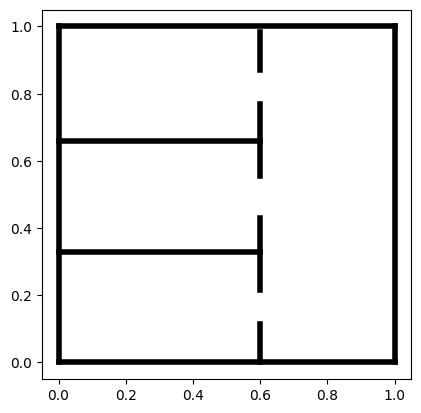

In [26]:
_, ax = plt.subplots()
ax.set_aspect("equal")
ev.make_room(name="flat2", thickness=4.).draw(ax=ax)
plt.show()

In [40]:
n = 5
M = np.abs(np.random.randn(5, 6)) * np.random.binomial(1, 0.4, size=(n, 6))
x = np.abs(np.random.randn(6, 1)) * np.random.binomial(1, 0.5, size=(6, 1))
M, x

(array([[1.01936285, 0.        , 0.        , 0.27045911, 0.22764006,
         0.        ],
        [0.        , 0.45812442, 0.        , 0.        , 0.79598999,
         0.11337728],
        [1.24584995, 0.        , 0.        , 0.14696168, 0.48911039,
         0.        ],
        [0.24638645, 0.        , 0.        , 0.71833177, 0.        ,
         0.95680702],
        [0.        , 0.        , 0.        , 0.        , 0.17722147,
         0.        ]]),
 array([[0.        ],
        [0.92211554],
        [0.        ],
        [0.39006404],
        [0.26186751],
        [0.        ]]))

In [43]:
(np.linalg.norm(M, axis=1) * np.linalg.norm(x))

array([1.11657638, 0.95767979, 1.39345929, 1.26418511, 0.1834068 ])

In [44]:
v = M@x / (np.linalg.norm(M, axis=1) * np.linalg.norm(x)).reshape(-1, 1)
print(np.around(v, 2))
v = utils.generalized_sigmoid(v, alpha=0.15, beta=1000)
np.around(v, 2)

[[0.15]
 [0.66]
 [0.13]
 [0.22]
 [0.25]]


array([[0.11],
       [1.  ],
       [0.  ],
       [1.  ],
       [1.  ]])

In [34]:
M.shape

(5, 5)

In [33]:
agent._pcnn._Wff.shape

(180, 169)

---

In [ ]:
reward = ga.Reward(start_pos=np.array([0.4, 0.8]),
                radius=0.05,
                onset=50)

heuristic = ga.Heuristic(params=[0.005, 2.5, 0.03, 0., 0.])

agent.reset(position=np.array([0.4, 0.3]))
agent.is_training = False

duration = 5_000
agent, r, = ga.run_random_agent(agent, env, reward,
                             duration=duration,
                             plot=False,
                             interval=200,
                             uprec=duration+1,
                             animate=False,
                                use_clf=False)
print(r, agent.distance)

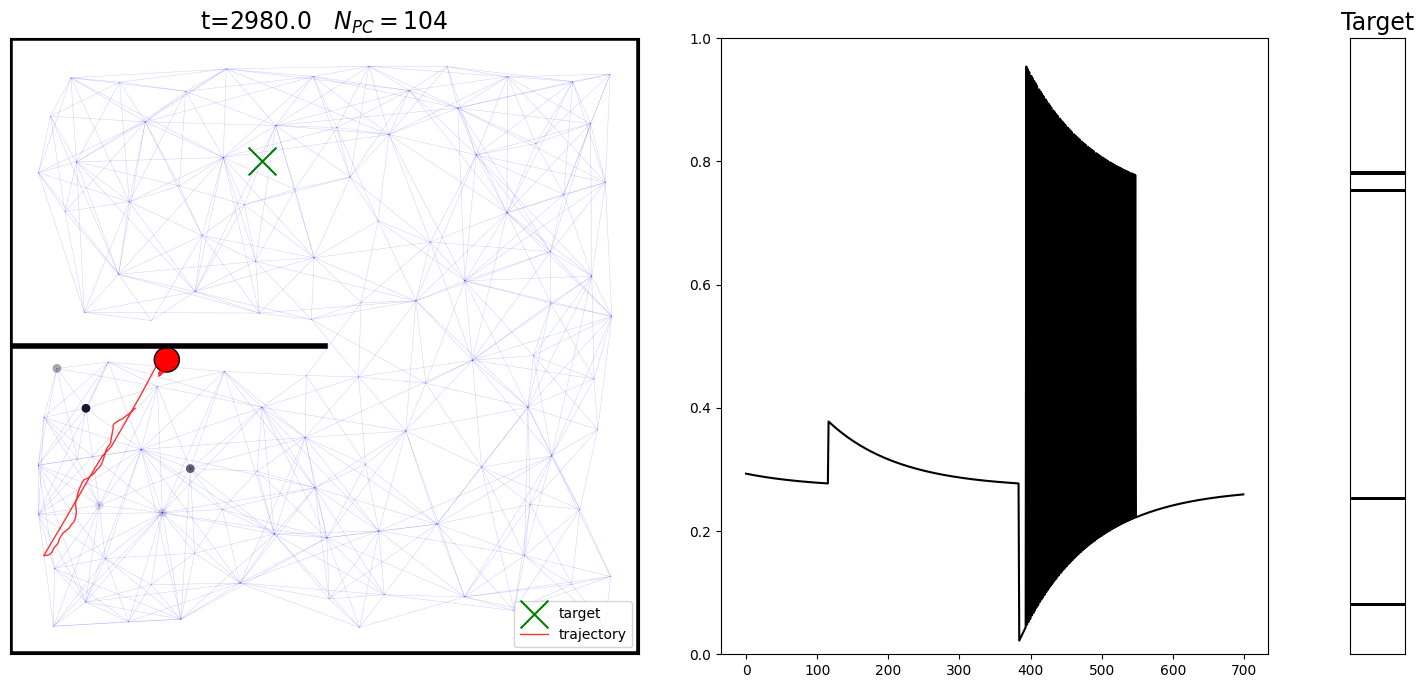

seed=3000
distance: 0.35414245712439923


In [95]:
#seed = int(input("seed: "))
#np.random.seed(seed)

reward = ga.Reward(start_pos=np.array([0.4, 0.8]),
                radius=0.02,
                onset=300)

heuristic = ga.Heuristic(params=[0.005, 2.5, 0.03, 0., 0.])

agent.reset(position=np.array([0.2, 0.4]))
agent.is_training = False

# plot
duration = 30_000

# Store positions
positions = np.zeros((duration, 2))

plot = True
interval = 200
animate = False
disable = False
use_clf = False

if False:
    fig = plt.figure(figsize=(18, 8))
    # make an axis on one column and two axes on the other
    # as a 1x2 grid
    gs = fig.add_gridspec(1, 3, width_ratios=[1.25, 1, 0.1])
    # gs = fig.add_gridspec(1, 2)
    ax = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    # fig.set_aspect('auto')

    env.draw(ax)
    agent.draw(ax)


animate = False
if animate:
    animation_maker = AnimationMaker(fps=10,
                                 use_logger=True,
                                 path=ANIM_PATH)



rec_size = 700
umax = []
achen = []
eps_ = []
R = 0

# colors
# Define the colors for each value
colors = ['white', 'black', 'red']

# Create a ListedColormap
custom_cmap = ListedColormap(colors)

# Run agent
for t in tqdm(range(duration), desc="Running agent",
              disable=True):

    # get target position
    reward_pos = reward(t=t)

    # update agent
    positions[t] = agent(trg_pos=reward_pos)

    # check reward
    if reward.check(agent.position):
        logger(f"Reached goal at t={t}")
        R = 1
        break

    # --- record & plot ---
    umax += [agent._pcnn.u.max()]
    achen += [int(agent._pcnn._ach_enabled)]
    eps_ += [agent.epsilon]

    if len(umax) > rec_size:
        del umax[0]
        del achen[0]
        del eps_[0]

    if plot and t % interval == 0:

        clf()
        fig = plt.figure(figsize=(18, 8))
        # make an axis on one column and two axes on the other
        # as a 1x2 grid
        gs = fig.add_gridspec(1, 3, width_ratios=[1.15, 1, 0.1])
        # gs = fig.add_gridspec(1, 2)
        ax = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        ax3 = fig.add_subplot(gs[0, 2])
        
        #ax2.imshow(agent.activity_record,
        #           cmap="Greys",
        #           vmin=0., vmax=1.,
        #           aspect="auto", interpolation="nearest")
        #ax2.set_yticks([])
        #ax2.set_xticks([])
        #ax2.set_xlabel("time", fontsize=15)
        #ax2.set_ylabel("neurons", fontsize=15)
        #ax2.set_aspect("auto")
        #ax2.set_title(f"Current representation",
        #ax2.set_title(f"{agent.heuristic}",
        #                  fontsize=17)

        ax2.plot(range(len(eps_)), eps_, "k-")
        ax2.set_ylim((0, 1))
        
        ax3.imshow(agent.trg_representation.reshape(-1,1),
                   cmap="Greys",
                   vmin=0.,
                   aspect="auto", interpolation="nearest")
        ax3.set_yticks([])
        ax3.set_xticks([])
        #ax3.set_xlabel("time", fontsize=15)
        #ax3.set_ylabel("neurons", fontsize=15)
        ax3.set_aspect("auto")
                    # ax2.set_title(f"Current representation",
        ax3.set_title(f"Target",
                          fontsize=17)


        if reward_pos is not None:
            ax.scatter(*reward_pos, c='green', s=400, marker='x', label="target")
        
        env.draw(ax)
        agent.draw(ax, show_pcnn=True, edge_alpha=0.2)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.legend(loc="lower right")
        # ax.set_aspect('equal')
        ax.set_title(f"t={t/10:.1f}   $N_{{PC}}=${len(agent._pcnn)}",
                     fontsize=17)
        
        plt.pause(0.001)

        if animate:
            animation_maker.add_frame(fig)

if animate:
    animation_maker.make_animation(
        name=f"rlroom_e_{time.strftime('%H%M%S')}")
    logger(f"animation saved at {ANIM_PATH}")
    animation_maker.play_animation(return_Image=False)

print(f"{seed=}")
print(f"distance: {agent.distance}")

In [143]:
agent._pcnn(x=reward.position.reshape(-1, 1)).T

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [33]:
heuristic(0.1)


(0.5436386872370789, 0.0)

## study 1

In [ ]:

fig, ax = plt.subplots()

for t in range(10):

    clf()
    ax.plot(t, np.sin(t/np.pi))
    plt.pause(0.5)

plt.show()

KeyboardInterrupt: 

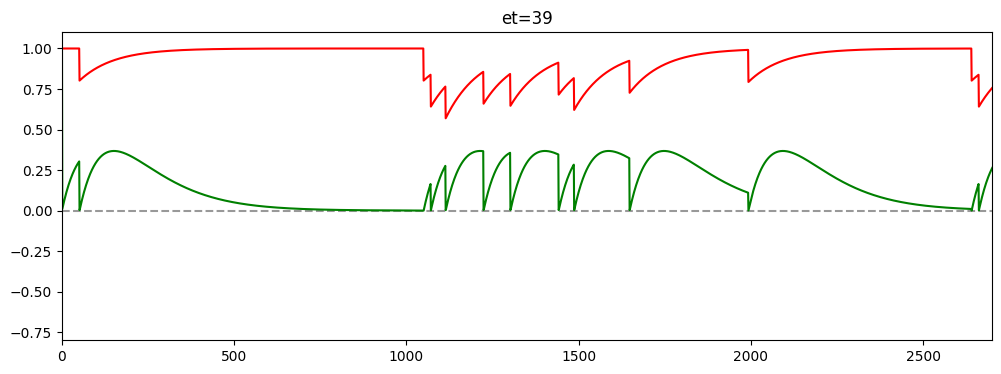

In [209]:
a = [1]
b = [1]
c = [1]
x = [1]
eqa = [1]
et = 0
net = 0

tot = 4_000

def pol(t):
    if t < 1000 or t > 4000:
        return np.random.binomial(1, 0.0005) * 0.99
    return np.random.binomial(1, 0.005) * 0.99

for t in range(tot):

    # dynamics
    I = pol(t)
    a += [
        max((0, a[-1] + (eqa[-1]-a[-1]) * 0.01)) #- I))
    ]
    b += [
        max((0, b[-1] + (1-b[-1]) * 0.01 * eqa[-1] - I))
    ]
    c += [
        c[-1] + (1-c[-1]) * 0.006 - I
    ]
    eqa += [
        max((0, eqa[-1] + (1-eqa[-1])*0.01 - I*0.2))
    ]


    if I == 0:
        et += 1
    else:
        et = 0
        x_prev = x[-1] if x else 0  # Store the previous concentration
    
    L = 0.01
    new_x = L * et * np.exp(-L * et)
    
    if I != 0:
        new_x += x_prev * L * np.exp(-L)  # Add decayed previous concentration
    
    x += [new_x]
        

    # plot
    if t % 20==0:
        clf()
        plt.figure(figsize=(12, 4))
        #plt.plot(range(t+2), a, 'k-')
        #plt.plot(range(t+2), b, 'b-')
        plt.axhline(0, alpha=0.4, color="black", linestyle="--")
        plt.plot(range(t+2), eqa, 'r-')
        plt.plot(range(t+2), x, 'g-')
        plt.ylim((-0.8, 1.1))
        plt.xlim((max((0, t-3000)), t))
        plt.title(f"{et=}")
        plt.pause(0.001)
        

## study 2: Bayesian agent

#### model 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta


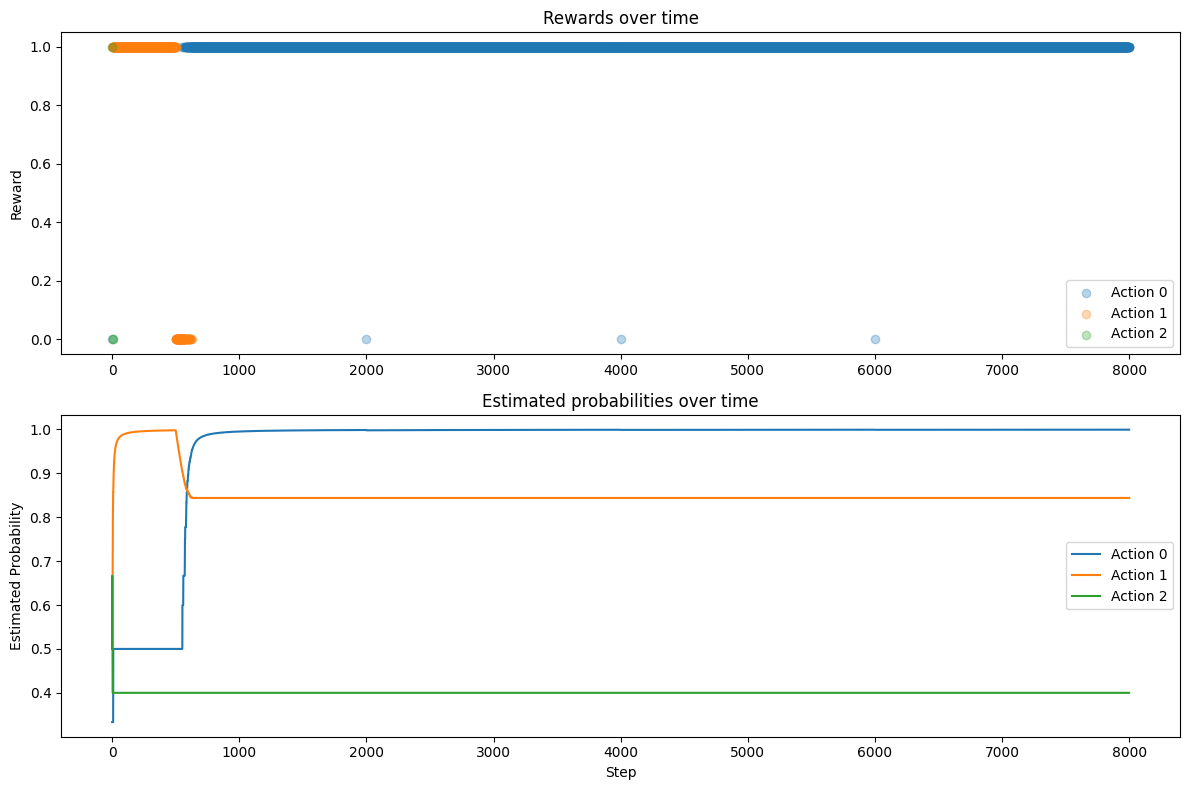

Final action probabilities: [0.99932542 0.84380306 0.4       ]


In [220]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

class BayesianRLAgent:
    def __init__(self, n_actions, prior_a=1, prior_b=1):
        self.n_actions = n_actions
        self.prior_a = prior_a
        self.prior_b = prior_b
        self.alpha = np.full(n_actions, prior_a)
        self.beta = np.full(n_actions, prior_b)
    
    def choose_action(self):
        samples = [beta.rvs(a, b) for a, b in zip(self.alpha, self.beta)]
        return np.argmax(samples)
    
    def update(self, action, reward):
        self.alpha[action] += reward
        self.beta[action] += (1 - reward)
    
    def get_action_probabilities(self):
        return self.alpha / (self.alpha + self.beta)

def patterned_reward(action, step):
    # This function creates a cyclical pattern of rewards
    cycle_length = 2000
    phase = step % cycle_length
    if action == 0:
        return np.sin(0.01*2 * np.pi * phase / cycle_length) > 0
    elif action == 1:
        return np.cos(2 * np.pi * phase / cycle_length) > 0
    else:
        return np.random.random() > 0.8

n_actions = 3
agent = BayesianRLAgent(n_actions)

n_steps = 8_000
chosen_actions = []
rewards = []
estimated_probs = []

for step in range(n_steps):
    action = agent.choose_action()
    reward = patterned_reward(action, step)
    agent.update(action, reward)
    
    chosen_actions.append(action)
    rewards.append(reward)
    estimated_probs.append(agent.get_action_probabilities())

# Convert to numpy arrays for easier manipulation
chosen_actions = np.array(chosen_actions)
rewards = np.array(rewards)
estimated_probs = np.array(estimated_probs)

# Plotting
plt.figure(figsize=(12, 8))

# Plot rewards
plt.subplot(2, 1, 1)
for action in range(n_actions):
    action_rewards = np.where(chosen_actions == action, rewards, np.nan)
    plt.scatter(range(n_steps), action_rewards, label=f'Action {action}', alpha=0.3)
plt.title('Rewards over time')
plt.ylabel('Reward')
plt.legend()

# Plot estimated probabilities
plt.subplot(2, 1, 2)
for action in range(n_actions):
    plt.plot(estimated_probs[:, action], label=f'Action {action}')
plt.title('Estimated probabilities over time')
plt.xlabel('Step')
plt.ylabel('Estimated Probability')
plt.legend()

plt.tight_layout()
plt.show()

print("Final action probabilities:", agent.get_action_probabilities())

#### model 2

In [6]:
class Env:
    def __call__(self, x, y):
        return 0.5*(np.sin(5*x) * np.cos(2*y) + np.cos(x))
    def plot(self)

        # Generate a meshgrid for plotting
        x = np.linspace(0, 1, 400)
        y = np.linspace(-1, 2, 400)
        X, Y = np.meshgrid(x, y)
        Z = func_rewarde(X, Y)
        
        # Plot the function
        plt.figure(figsize=(8, 6))
        cp = plt.contourf(X, Y, Z, cmap='viridis')
        plt.colorbar(cp)
        plt.title('Non-linear 2-valued Function')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()


SyntaxError: incomplete input (3799517659.py, line 2)

In [8]:
from scipy.stats import beta

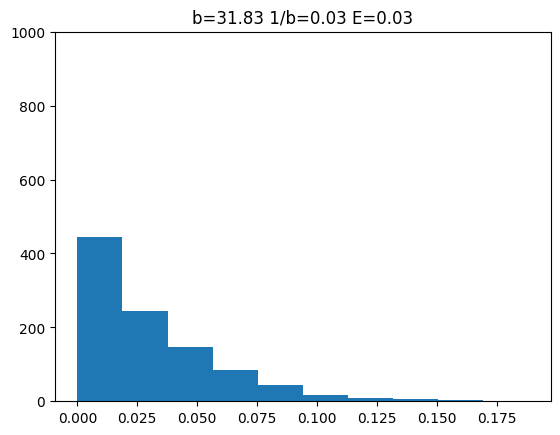

KeyboardInterrupt: 

In [46]:
for b in np.linspace(0.001, 100, 1000):
    clf()
    x = beta.rvs(1, b, size=1000)
    _, _, _ = plt.hist(x, bins=10)
    plt.ylim(0, 1000)
    plt.title(f"{b=:.2f} {1/b=:.2f} E={1/(1+b):.2f}")
    plt.pause(0.001)


In [144]:
from scipy.stats import beta
from src.simplerl import scratch as sc

In [156]:
class BetaBayes:

    def __init__(self, a=1, b=1, lr=0.1):

        self.alpha = a
        self.beta = b
        self.lr = lr
        self.action = 0
        
    def __call__(self):
        self.action = (beta.rvs(self.alpha, self.beta) > 0.5) *1
        return self.action

    def update(self, reward):
 
        if reward == 0:
            return

        update_value = self.lr * reward
        
        if reward > 0:
            if self.action > 0.5:
                #self.alpha += update_value
                self.beta *= 1-self.lr
            else:
                #self.beta += update_value
                self.beta *= 1+self.lr
        else:
            if self.action > 0.5:
                self.beta *= 1+self.lr
                #self.alpha += update_value #/ 2
            else:
                self.beta *= 1-self.lr
                #self.beta += update_value #/ 2

        self._normalize()

    def _normalize(self):
        #self.alpha = max(self.alpha, 0.3)
        #self.beta = max(self.beta, 0.3)
        #self.alpha = np.clip(self.alpha, 0.1, 0.9)
        self.beta = np.clip(self.beta, 1/5, 5)


In [162]:
p = 1#(np.random.random() > 0.5)*1
agent = sc.BetaBayes(lr=1., min_value=0.2)

fig, (ax, ax1) = plt.subplots(1, 2)

R = []
P = []

for t in range(1000):

    if t % 100 == 1:
        p = 0 if p == 1 else 1
    #if t == 200:
    #    p = 0
    
    action = agent()
    r = 1*(action==p)
    agent.update(reward=r)

    R += [action]
    P += [p]

    if t % 3 ==0:
        clf()
        fig, (ax, ax1) = plt.subplots(1, 2, figsize=(15, 5))
        ax.plot(R)
        ax.plot(P, lw=5, alpha=0.4)
        ax.set_title(f"{t=}  -  $\\alpha$={agent.alpha:.2f}, $\\beta$={agent.beta:.2f}  - rew={r} p={p} action={action}", fontsize=15)
        ax.set_xlim((max((0, t-200)), t))
        ax.set_ylim((-0.2, 1.2))

        ax1.bar([0, 1], [agent.alpha, agent.beta])
        plt.pause(0.001)
        


KeyboardInterrupt: 

In [166]:
0 % 3, 1 % 3, 2 % 3, 3 % 3

(0, 1, 2, 0)

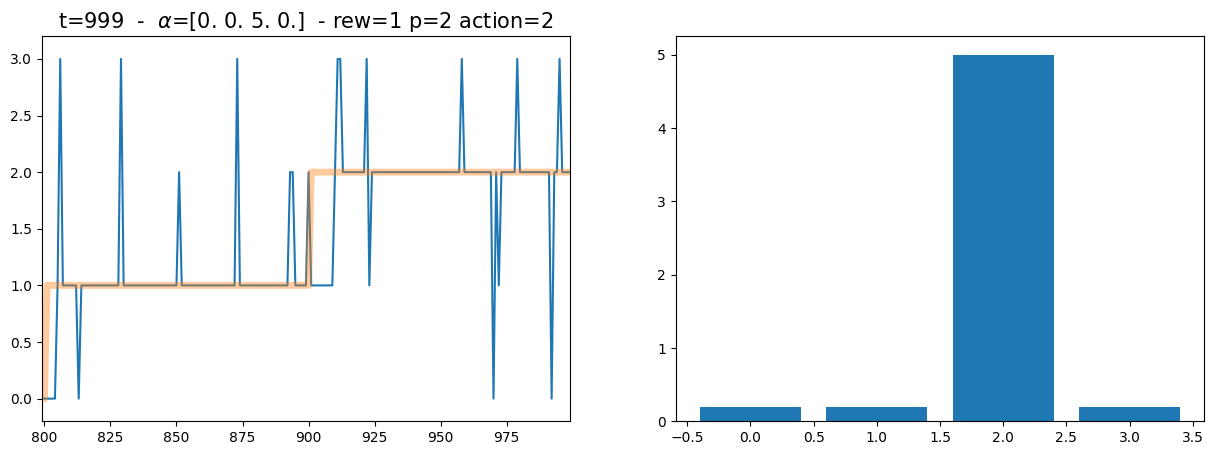

In [204]:
p = 0
K = 4
agent = sc.DirichletBayes(lr=1., min_value=0.2, K=K)

fig, (ax, ax1) = plt.subplots(1, 2)

R = []
P = []

for t in range(1000):

    if t % 100 == 1:
        p += 1
        p = p % K
    #if t == 200:
    #    p = 0
    
    action = agent()
    
    r = 1*(action==p)
    agent.update(reward=r)

    R += [action]
    P += [p]

    if t % 3 ==0:
        clf()
        fig, (ax, ax1) = plt.subplots(1, 2, figsize=(15, 5))
        ax.plot(R)
        ax.plot(P, lw=5, alpha=0.4)
        alphas = np.around(agent.alphas)
        ax.set_title(f"{t=}  -  $\\alpha$={alphas}  - rew={r} p={p} action={action}", fontsize=15)
        ax.set_xlim((max((0, t-200)), t))
        ax.set_ylim((-0.2, K-1+.2))

        ax1.bar(range(K), agent.alphas.tolist())
        plt.pause(0.001)
        


In [83]:
beta.rvs(agent.alpha, agent.beta)

0.5912567930278771

## study 3: ODE agent

In [2]:
import os
os.chdir("/Users/daniekru/Research/lab/PCNN/src/simplerl")
import geneticalgo as ga
 
from copy import deepcopy

In [3]:
## --- instantiate the agent ---
# PCNN
params = {
    "N": 180,
    "Nj": 13**2,
    "tau": 10.0,
    "alpha": 16_000.,
    "beta": 20.0, # 20.0
    "lr": 0.1,
    "threshold": 1.,#kwargs.get("threshold", 0.09),
    "ach_threshold": 0.7,#args.ach_threshold,
    "da_threshold": 0.7,
    "tau_ach": 200.,  # 2.
    "eq_ach": 1.,
    "tau_da": 50.,#args.tau,  # 2.
    "eq_da": 0.,
    "epsilon": 0.3,
    "rec_epsilon": 0.001,# kwargs.get("rec_epsilon", 0.1),
}

pcnn_model = pw.PCNNlayer(pcnn_params=params,
                          sigma=0.01,
                          calc_graph_enable=False)
pcnn_model._calc_recurrent_enable = False

# room
room = ev.make_room(name="square1", thickness=4.)
logger(room)

logger(f"PCNN: {pcnn_model}")
agent_body = ga.RandomAgent(position=np.array([0.4, 0.4]),
                    room=room,
                    pcnn=pcnn_model,
                    heuristic=None,
                    policy="drift",
                    speed=0.002,
                    turn_rate=0.13,
                    radius=0.02,
                    epsilon=0.0)

# --- pre-training ---
pre_duration = 80_000

reward = ga.Reward(start_pos=np.array([0.8, 0.8]),
                onset=pre_duration+1,  # inactive
                radius=0.03)
agent_body, _, = ga.run_random_agent(agent_body, room, reward,
                             duration=pre_duration,
                             plot=False,
                             interval=20,
                             uprec=10000,
                             use_clf=False,
                             animate=False,
                                    disable=False)
agent_body._update_connections()
logger("Pre-training done")

# --- policy training ---
agent_body.reset()
agent_body.is_training = False

2024-10-07 13:48:43 | Layer(N=169, kind=`place`) - sigma=0.01
2024-10-07 13:48:43 | Room.Square(#walls5)
2024-10-07 13:48:43 | PCNN: PCNNlayer(N=180, Nj=169, lr=0.1)
2024-10-07 13:48:43 | running agent
Running agent:   0%|                                                                                                      | 0/80000 [00:00<?, ?it/s]/Users/daniekru/Research/lab/PCNN/src/minimal_model.py:1353: RuntimeWarning: invalid value encountered in divide
  M = M / np.linalg.norm(M, axis=1, keepdims=True)
Running agent:   0%|                                                                                          | 1/80000 [00:04<103:00:17,  4.64s/it]/Users/daniekru/Research/lab/PCNN/src/minimal_model.py:1353: RuntimeWarning: invalid value encountered in divide
  M = M / np.linalg.norm(M, axis=1, keepdims=True)
Running agent:   0%|                                                                                           | 2/80000 [00:04<44:27:05,  2.00s/it]/Users/daniekru/Research/l

In [4]:
agent_body._pcnn.__len__()

106

In [5]:
pcnn = deepcopy(agent_body._pcnn)
logger(".")

2024-10-07 13:56:25 | .


(None, 106)

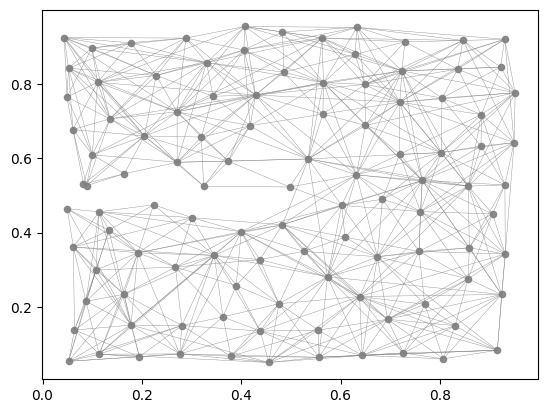

In [6]:
agent_body._pcnn.render(), agent_body._pcnn.__len__()

In [107]:
""" load agent body """
agent_body = ga.RandomAgent(position=np.array([0.4, 0.4]),
                    room=room,
                    pcnn=pcnn_model,
                    heuristic=None,
                    policy="drift",
                    speed=0.002,
                    turn_rate=0.13,
                    radius=0.02,
                    epsilon=0.0)
agent_body._pcnn = pcnn
logger(agent_body)

2024-10-07 15:36:24 | <class 'geneticalgo.RandomAgent'>


In [108]:
# new reward
reward = ga.Reward(start_pos=np.array([0.4, 0.8]),
                onset=1,
                radius=0.07)

# observer
observer = ga.Observer(shape_ext=(1,), shape_repr=(pcnn_model.N,),
                    tau=10.0)

# make env
env = ga.CampoBlue(reward=reward,
                agent=agent_body,
                observer=observer,
                  duration=10_000)

duration = 10_000

logger(f"duration: {duration}")

agent_name = "hII"
if agent_name not in ["dummy", "hII"]:
    from stable_baselines3 import PPO, A2C, TD3, DDPG, DQN

# --- train the agent ---
# Train the agent for 10,000 timesteps

# Create the PPO agent
if agent_name == "ppo":
    agent = PPO("MlpPolicy", env, verbose=1)
elif agent_name == "a2c":
    agent = A2C("MlpPolicy", env, verbose=1)
elif agent_name == "td3":
    agent = TD3("MlpPolicy", env, verbose=1)
elif agent_name == "ddpg":
    agent = DDPG("MlpPolicy", env, verbose=1)
elif agent_name == "dqn":
    agent = DQN("MlpPolicy", env, verbose=1)
elif agent_name == "dummy":
    agent = ga.LocalDummy()
elif agent_name == "hII":
    agent = ga.HeuristicII(tau1=100, tau2=100, threshold1=0.0001, threshold2=0.0001, delay=150)

else:
    raise ValueError("agent not found")

logger(agent)


2024-10-07 15:36:25 | duration: 10000
2024-10-07 15:36:25 | HeuristicII(delay=150)


Running agent:  12%|███████████                                                                                | 1210/10000 [00:46<05:37, 26.05it/s]
Traceback (most recent call last):
  File "/Users/daniekru/Research/codebase/myenvs/env_cl1/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/77/b66qkr5d21l_3nnw6f563fw80000gp/T/ipykernel_5489/1318730434.py", line 6, in <module>
    _ = ga.run_simple_episode(agent=agent,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/daniekru/Research/lab/PCNN/src/simplerl/geneticalgo.py", line 999, in run_simple_episode
  File "/Users/daniekru/Research/lab/PCNN/src/simplerl/geneticalgo.py", line 1097, in render
    plt.scatter(*self.reward.position, c='red', s=100, marker='x')
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/daniekru/Research/lab/PCNN/src/simplerl/geneticalgo.py", line 336, in draw
  File "/Users/daniek

Unexpected exception formatting exception. Falling back to standard exception


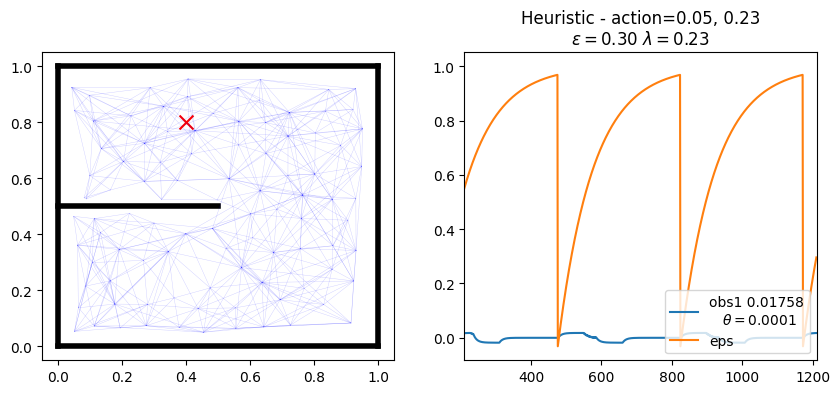

In [109]:
# """ run an episode """
logger("testing agent...")


for _ in range(10):
    _ = ga.run_simple_episode(agent=agent,
                           env=env,
                           reward=reward,
                           tper=10, use_clf=True, use_a=True)
    time.sleep(1)

In [21]:
agent_body._pcnn.centers.shape

(180, 2)

In [581]:
agent_body.velocity

array([0.00057711, 0.00191493])

#### two lines

$y=(a/b)*x+d$

$by=ax+db$

$ax-by+db=0$